# Primo prototipo di modello ML: decision tree

Liberie varie da installare

In [21]:
#!pip install pandas
#!pip install sklearn
#!pip install seaborn
#!pip install imblearn

Inclusione delle librerie utilizzate

In [22]:
from os.path import exists
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import tree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

Variabili di gestione files, parametri del modello e della fase di training

In [23]:
# Path of the dataset in .pkl format, can be changed
PATH_DATASET = r"C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\Dataset_output\filtered_active_bankruptcy_big.pkl"

# True = Standardize data, can be changed
to_standardize = True

# True = Oversample the least populated class (Bankruptcy), can be changed
avoid_imbalanced_training = True

# True = Oversample/Undersample the least/most populated class (Bankruptcy), can be changed
# It only affects the notebook if avoid_imbalanced_training is True
imbalanced_data_technique = "Oversample"

# True = Also use non financial indexes features like the legal form or the size of the company
additional_features = True

# A value between [0, 1], it represent the percentage of records not used during training time, can be changed
train_test_split_amount = 0.25

# Select a random state value in order to control the randomness effect, can be changed
rnd_state = 25

# Specify the number of cuncurrent jobs in order to speed up certain traning phases.
# Specify -1 in order to use all the job available, the default one is 1, can be changed
n_jobs = -1

# True = Export the current experiment inside the dataframe that collects all of them, can be changed
to_export = True

# Path of the dataset in .pkl format to store all the experiments, can be changed and if not present it will be created
OUTPUT_PATH = r"C:\Users\Andre\OneDrive - Università degli Studi di Parma\Tirocinio\ML_models"

Controllo se esiste il dataset di output

In [24]:
# Only if we want to export
if to_export:
    if exists(OUTPUT_PATH + "/ML_model_experiments.pkl"):
        # If the dataset exists, read it
        output_dataset = pd.read_pickle(OUTPUT_PATH + "/ML_model_experiments.pkl")
        print("Dataset di output trovato")
    else:
        # Otherwise create it
        output_dataset = pd.DataFrame()
        print("Dataset di output non trovato, creo un nuovo dataset")

Dataset di output trovato


Lettura del dataset di input

In [25]:
dataset = pd.read_pickle(PATH_DATASET)
print("Il dataset da utilizzare ha", dataset.shape[0], "record e", dataset.shape[1], "colonne")

Il dataset da utilizzare ha 1207856 record e 22 colonne


Suddivisione del dataset in X e Y, dove X sono le features in ingresso (indicatori finanziari) e Y è la risposta in output (attivo/bancarotta)

In [26]:
X_features_names = ['PN/Totale Debiti',
                    'Deb. Prev + Trib/Attivo',
                    'Tempo medio riscossione (TMR)',
                    'Tempo medio di pagamento (TMP)',
                    'PFN/EBITDA',
                    'PFN/PN',
                    'Gearing',
                    'ROS',
                    'Working capital/net sales',
                    'Cash/Current Liabilities',
                    'Accounts receivable/inventory',
                    'EBIT/interest expenses',
                    'Att.Br/Attivo',
                    'Ricavi/Attivo',
                    'EBITDA/Totale Debiti']

if additional_features:
    X_features_names.append('Legal Form')
    X_features_names.append('Number of employees')
    #X_features_names.append('Company Size')

Y_feature_name = 'Legal Status'

X_dataset = dataset[X_features_names].copy()

if additional_features:
    # One hot encoding
    X_dataset = X_dataset.join(pd.get_dummies(dataset['Legal Form']))
    X_dataset.drop('Legal Form', axis = 1, inplace=True)

    #X_dataset = X_dataset.join(pd.get_dummies(dataset['Company Size']))
    #X_dataset.drop('Company Size', axis = 1, inplace=True)

    # Save the new feature names
    X_features_names = X_dataset.columns.to_list()

Y_dataset = dataset[Y_feature_name].copy()

Stampo i primi record dei 2 nuovi dataset per chiarezza

In [27]:
X_dataset.head()

,PN/Totale Debiti,Deb. Prev + Trib/Attivo,Tempo medio riscossione (TMR),Tempo medio di pagamento (TMP),PFN/EBITDA,PFN/PN,Gearing,ROS,Working capital/net sales,Cash/Current Liabilities,Accounts receivable/inventory,EBIT/interest expenses,Att.Br/Attivo,Ricavi/Attivo,EBITDA/Totale Debiti,Number of employees,Altro,Società di capitali,Società di persone
0,0.062759,0.018469,132.395004,75.595004,4.934119,10.264500,0.911226,0.083199,0.775917,0.090424,1.128547,3.595384,0.894619,1.152983,0.130558,3,0,1,0
1,0.004904,0.000047,5.730942,2083.270723,-179.934494,174.011292,0.994286,-0.377653,79.832063,0.009702,0.000200,-5053.000000,0.997454,0.012494,-0.004743,0,0,1,0
3,0.210145,0.012336,59.357925,80.109660,9.836861,3.533378,0.779414,0.071155,0.322540,0.004904,2.418841,1.184761,0.212252,0.658064,0.075484,3,0,1,0
5,0.066812,0.032663,147.727157,124.675919,-9.566669,7.865999,0.887210,-0.094270,0.678891,0.000062,1.716560,-18.549697,0.846830,1.247374,-0.054935,65,0,1,0
6,0.022278,0.060303,103.584818,183.539200,-7.343600,-15.127474,1.070784,0.027636,0.512299,0.337007,0.000000,178.388889,0.755045,1.473838,0.045891,6,0,1,0


In [28]:
Y_dataset.head()

0    Active
1    Active
3    Active
5    Active
6    Active
Name: Legal Status, dtype: object

Codifico la variabile di risposta (Active/Bankruptcy) in (0/1)

In [29]:
Y_dataset.replace({"Active": 0, "Bankruptcy": 1}, inplace=True)
Y_dataset.head()

0    0
1    0
3    0
5    0
6    0
Name: Legal Status, dtype: int64

Controllo il numero di record per ciascuna classe

In [30]:
Y_dataset.value_counts()

0    908518
1    299338
Name: Legal Status, dtype: int64

Uso la tecnica di random oversampling o undersampling per evitare un allenamento di un modello con classi sbilanciate

In [31]:
if avoid_imbalanced_training:
    # Oversample
    if imbalanced_data_technique == "Oversample":
        sm = SMOTE(random_state=rnd_state, n_jobs=n_jobs)
        X_dataset, Y_dataset = sm.fit_resample(X_dataset, Y_dataset)
    # Undersample
    elif imbalanced_data_technique == "Undersample":
        undersample = RandomUnderSampler(sampling_strategy='majority', random_state=rnd_state)
        X_dataset, Y_dataset = undersample.fit_resample(X_dataset, Y_dataset)
    else:
        print("Error: wrong variable value about imbalanced data")
Y_dataset.value_counts()

0    908518
1    908518
Name: Legal Status, dtype: int64

Standardizzo i dati contenuti in X

In [32]:
if to_standardize:
    scaler = StandardScaler()
    X_dataset = scaler.fit_transform(X_dataset)

Divido i 2 dataset in train e test

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dataset,
                                                    Y_dataset,
                                                    stratify=Y_dataset,
                                                    test_size=train_test_split_amount,
                                                    random_state=rnd_state)

Creo primo prototipo di decision tree e lo alleno sui dati di train

In [34]:
decision_tree_classifier = tree.DecisionTreeClassifier(random_state=rnd_state)
decision_tree_classifier.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=25)

Guardo come si comporta sui dati di test che il modello non ha mai visto

In [35]:
Y_predicted = decision_tree_classifier.predict(X_test)
score = accuracy_score(Y_test, Y_predicted)

print("L'accuratezza è", score)

L'accuratezza è 0.8146630006229926


Curva ROC

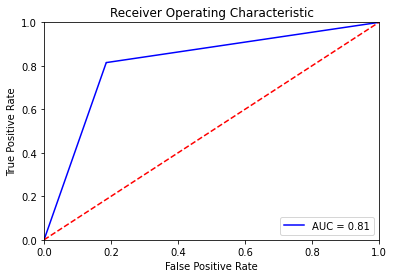

In [36]:
probs = decision_tree_classifier.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Matrice di confusione

[Text(0, 0.5, 'Active'), Text(0, 1.5, 'Bankruptcy')]

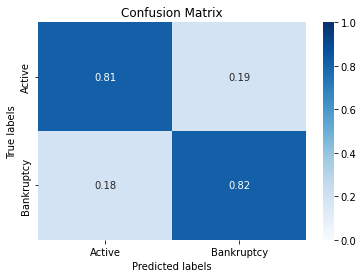

In [37]:
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_predicted)
conf_matrix = conf_matrix / conf_matrix.astype(np.float64).sum(axis=1)

ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, vmin=0.0, vmax=1.0, fmt=".2f", cmap="Blues", ax=ax)

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Active', 'Bankruptcy'])
ax.yaxis.set_ticklabels(['Active', 'Bankruptcy'])

Mostro l’importanza di ogni feature

<AxesSubplot:>

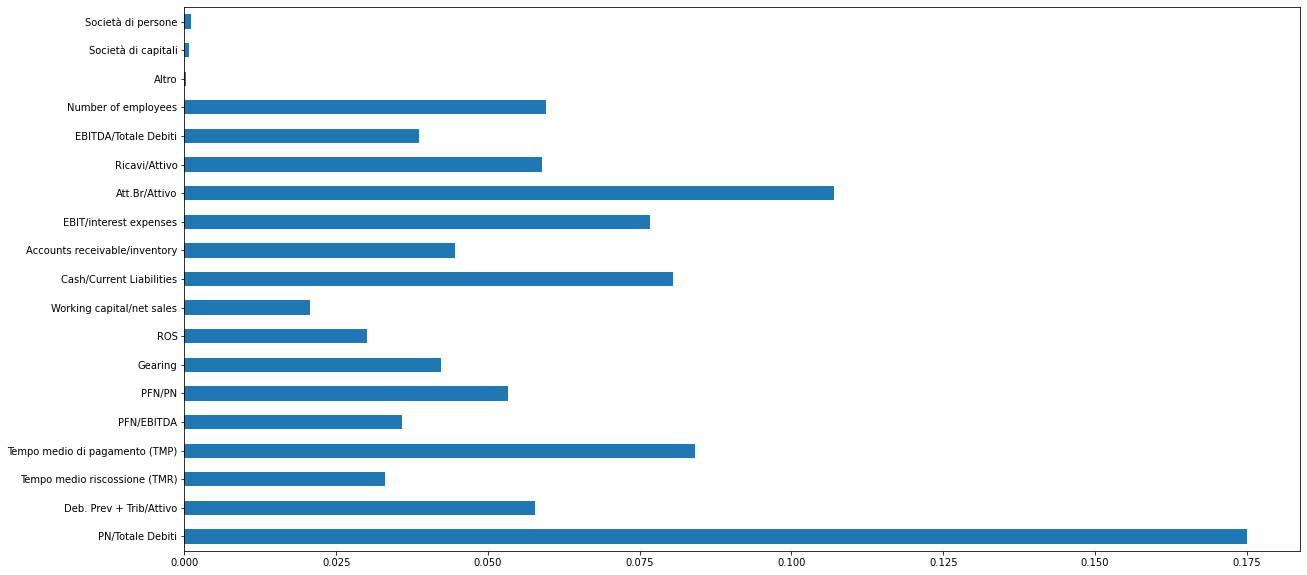

In [38]:
plt.figure(figsize=(20,10))
feat_importances = pd.Series(decision_tree_classifier.feature_importances_, index=X_features_names)
feat_importances.plot(kind='barh')

Stampo in formato testuale il decision tree

In [39]:
text_representation = tree.export_text(decision_tree_classifier, feature_names=X_features_names)
print(text_representation)

|--- PN/Totale Debiti <= -0.01
|   |--- Att.Br/Attivo <= -1.57
|   |   |--- PFN/PN <= 0.00
|   |   |   |--- PN/Totale Debiti <= -0.01
|   |   |   |   |--- PFN/PN <= -0.00
|   |   |   |   |   |--- Tempo medio di pagamento (TMP) <= -0.01
|   |   |   |   |   |   |--- Deb. Prev + Trib/Attivo <= -0.00
|   |   |   |   |   |   |   |--- Gearing <= 0.01
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Gearing >  0.01
|   |   |   |   |   |   |   |   |--- PFN/EBITDA <= -0.03
|   |   |   |   |   |   |   |   |   |--- Att.Br/Attivo <= -2.06
|   |   |   |   |   |   |   |   |   |   |--- PFN/EBITDA <= -0.03
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- PFN/EBITDA >  -0.03
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- Att.Br/Attivo >  -2.06
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- PFN/EBITDA >  -0.03
|   |   |   |   

Esporto l’esperimento nel dataset di output

In [40]:
if to_export:
    if not avoid_imbalanced_training:
        imbalanced_data_technique = "N.A."

    # Compute metrics to be added to the dataset
    accuracy = accuracy_score(Y_test, Y_predicted)
    precision = precision_score(Y_test, Y_predicted)
    recall = recall_score(Y_test, Y_predicted)
    f1 = f1_score(Y_test, Y_predicted)

    # Create a new record
    new_record = pd.DataFrame({"Date": [date.today()],
                               "Model type": ["Decision Tree"],
                               "Model parameters": [decision_tree_classifier.get_params()],
                               "Data source": [PATH_DATASET.split("\\")[-1]],
                               "Features": [X_features_names],
                               "Standardized": [to_standardize],
                               "Imbalanced data corrections": [avoid_imbalanced_training],
                               "Imbalanced data technique": [imbalanced_data_technique],
                               "Number of active companies used": [Y_dataset.value_counts()[0]],
                               "Number of bankruptcy companies used": [Y_dataset.value_counts()[1]],
                               "Train/Test split": [train_test_split_amount],
                               "Random state": [rnd_state],
                               "Accuracy": [accuracy],
                               "Precision": [precision],
                               "Recall": [recall],
                               "F1-score": [f1],
                               "AUC": [roc_auc]})

    # Append the new record
    output_dataset = pd.concat([output_dataset, new_record], ignore_index=True, axis=0)

    # Export the dataset
    output_dataset.to_pickle(OUTPUT_PATH + "/ML_model_experiments.pkl")
    print("Esprimento aggiunto al dataset")

Esprimento aggiunto al dataset


Provo utilizzando la tecnica del cross-validation score

In [ ]:
start_split = 5
end_split = 21
for n_split in range(start_split, end_split, 5):
    # prepare the cross-validation procedure
    cv = KFold(n_splits=n_split, random_state=rnd_state, shuffle=True)
    # create model
    decision_tree_classifier_cv = tree.DecisionTreeClassifier(random_state=rnd_state)
    # evaluate model
    scores = cross_val_score(decision_tree_classifier_cv, X_dataset, Y_dataset, scoring='accuracy', cv=cv, n_jobs=n_jobs)
    # report performance
    print("L'accuratezza con", n_split, "split è", np.mean(scores))

Testiamo diversi decision tree con parametri diversi (hypertuning parameters)

In [ ]:
# Each list contains all the value of a specific hyperparameter we want to test
decision_tree_parameter_criterions = ["entropy", "gini"]
decision_tree_parameter_min_samples_splits = [2, 5, 10, 100, 1000]
decision_tree_parameter_min_samples_leaves = [1, 2, 5, 10, 100, 1000]

# List to save each score
decision_tree_scores = []

# Iterate over each parameter
for criterion in decision_tree_parameter_criterions:
    for min_samples_split in decision_tree_parameter_min_samples_splits:
        for min_samples_leaf in decision_tree_parameter_min_samples_leaves:
            # Create the decision tree with the desired parameters
            test_decision_tree = tree.DecisionTreeClassifier(criterion=criterion,
                                                             min_samples_split=min_samples_split,
                                                             min_samples_leaf=min_samples_leaf,
                                                             random_state=rnd_state)
            # Train the model
            test_decision_tree.fit(X_train, Y_train)
            # Test the model
            Y_predicted = test_decision_tree.predict(X_test)
            # Obtain the accuracy
            score = accuracy_score(Y_test, Y_predicted)
            # Add the results to the list
            decision_tree_scores.append((criterion, min_samples_split, min_samples_leaf, score))
            # Print the result (unordered)
            print("Criterion:", criterion,
                  "min_samples_split:", min_samples_split,
                  "min_samples_leaf:", min_samples_leaf,
                  "--- SCORE:", score)

In [ ]:
# Print the result (ordered)
decision_tree_scores.sort(key=lambda x:x[-1], reverse=True)

for criterion, min_samples_split, min_samples_leaf, score in decision_tree_scores:
    print("Criterion:", criterion,
          "min_samples_split:", min_samples_split,
          "min_samples_leaf:", min_samples_leaf,
          "--- SCORE:", score)